In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import minimize, curve_fit
# Step 2: Enable interactive mode for Jupyter Notebook
%matplotlib inline
np.set_printoptions(formatter={'float_kind': lambda x: f"{x:0.6f}"})

# 1. Load and display data

In [122]:
df = pd.read_excel('data4.xlsx')

In [123]:
df

,x1,x2,x3,x4,y,Notes
0,0.948389,0.894513,0.851638,0.552196,-32.625660,NaN
1,0.683486,0.902770,0.335420,0.999483,-29.427091,NaN
2,0.985622,0.666933,0.156783,0.856535,-28.903274,NaN
3,0.957135,0.597644,0.766114,0.776210,-27.316396,NaN
4,0.859657,0.919592,0.206139,0.097797,-26.857786,NaN
5,0.167130,0.876555,0.217240,0.959801,-26.561821,NaN
6,0.854811,0.493965,0.735310,0.808092,-23.139428,NaN
7,0.896981,0.725628,0.175404,0.701694,-22.108288,NaN
8,0.664955,0.046566,0.116777,0.793718,-19.989498,NaN
9,0.387488,0.804532,0.751795,0.723827,-19.441558,NaN


In [124]:
df = df.drop(columns=['Notes'])
df=df.dropna()

# 2. Visualise data on plots

In [125]:
# two highest points in top_2_indices will have color in red
top_2_indices = df['y'].nlargest(2).index
top_qntl_index = df['y'].nlargest(int(df.shape[0]/7.0)).index
colors = np.full(df.shape[0], 'b', dtype=object)  # Default color is blue

In [126]:
# Find the closest 5 points to maximum and color them differently
# it helps to understand if to use linear gradient
X = df.iloc[:,:-1].to_numpy()
y = df.iloc[:,-1].to_numpy()
# Find the maximum value in y and its index
max_index = df['y'].nlargest(1).index[0]
max_value = y[max_index]
# Calculate distances from the point with maximum y to all other points
distances = np.linalg.norm(X - X[max_index], axis=1)
closest_indices = np.argsort(distances)[1:5]
indices_to_use = np.concatenate(([max_index], closest_indices))
print("Average distance",distances[indices_to_use].mean())
colors[indices_to_use] = 'y'
colors[max_index] = 'r'  # Color top points red
# Show the closest 5 points to maximum
df.iloc[indices_to_use,:]

Average distance 0.06469551043809166


,x1,x2,x3,x4,y
45,0.386697,0.353441,0.363096,0.372660,0.541030
48,0.417644,0.361916,0.396890,0.381777,0.504378
50,0.433670,0.395756,0.346161,0.389168,0.315870
49,0.424067,0.394525,0.300289,0.399794,-1.101451
47,0.391464,0.387823,0.475736,0.397089,-1.894206


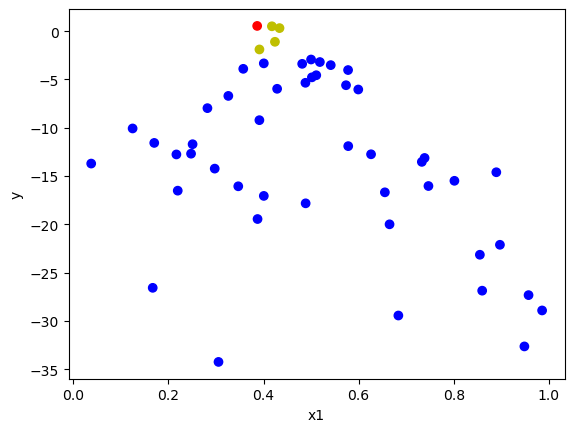

In [127]:
plt.scatter(df['x1'],df['y'], c = colors)
# Highlight the two highest y values
plt.ylabel('y')
plt.xlabel('x1')
plt.show()

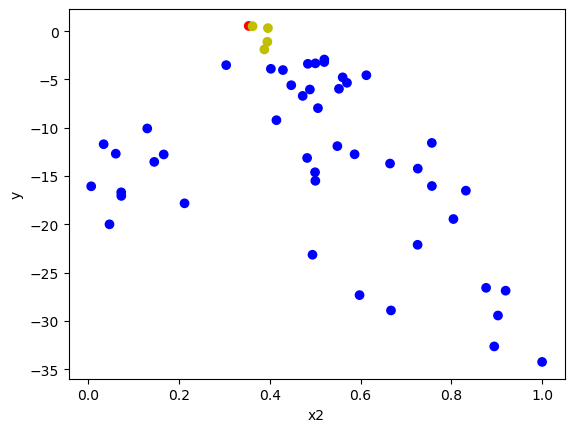

In [128]:
plt.scatter(df['x2'],df['y'], c = colors)
# Highlight the two highest y values
plt.ylabel('y')
plt.xlabel('x2')
plt.show()

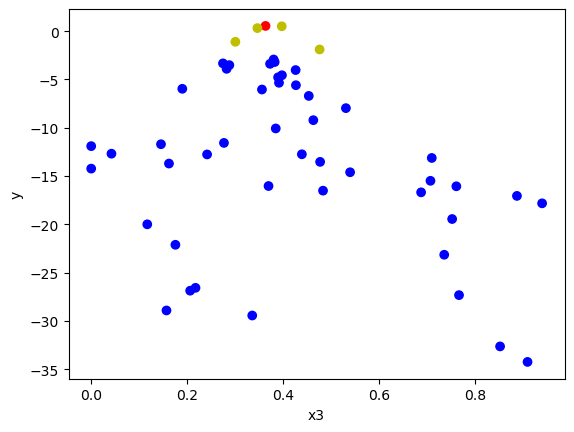

In [129]:
plt.scatter(df['x3'],df['y'], c = colors)
# Highlight the two highest y values
plt.ylabel('y')
plt.xlabel('x3')
plt.show()

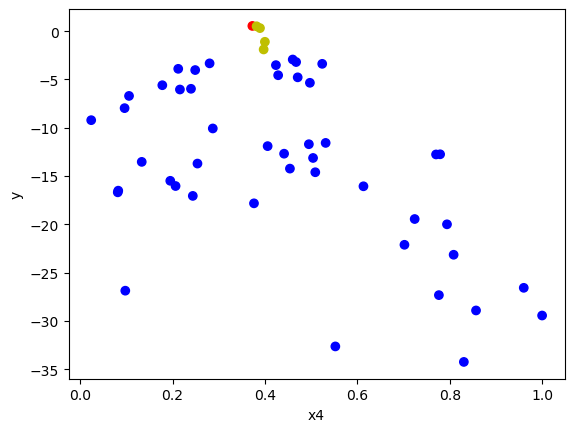

In [130]:
plt.scatter(df['x4'],df['y'], c = colors)
# Highlight the two highest y values
plt.ylabel('y')
plt.xlabel('x4')
plt.show()

# You can rotate in 3 dimentions

<IPython.core.display.Javascript object>


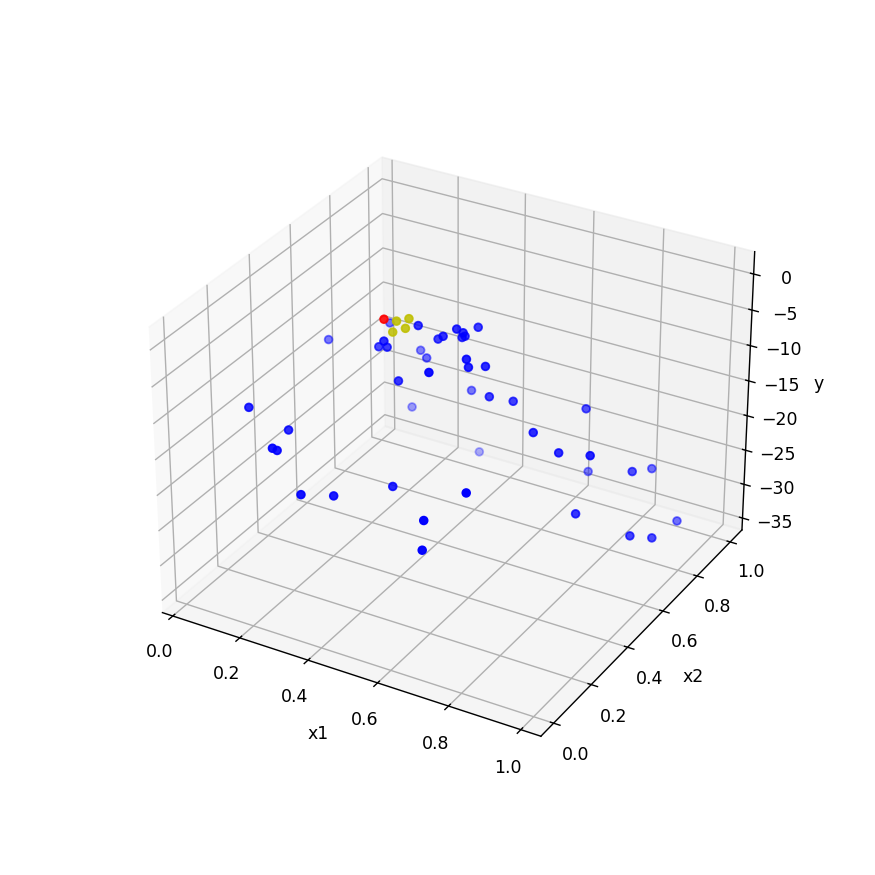

In [131]:
# Updated this code to see other dimentions
%matplotlib notebook
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
# Plot the surface
ax.scatter(df['x1'], df['x2'], df['y'], c = colors)
# Set labels
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
# Display the plot
plt.show()

In [133]:
%matplotlib inline

# 3. Build the grid for Optimization
fine tune the size of grid for high dimention!

In [134]:
x = np.linspace(0,0.999999,51).reshape(-1,1)

In [135]:
x_grid = np.array([[x1, x2, x3, x4] for x1 in x for x2 in x for x3 in x for x4 in x ])

In [136]:
x_grid = x_grid.squeeze()

# 4. Use Gaussian Process Regressor with Radial Based Function 

In [137]:
from sklearn.gaussian_process.kernels import RBF, Matern, ExpSineSquared
kernel = RBF(length_scale=0.2, length_scale_bounds=(1e-3, 1e4))
#bo_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-13, n_restarts_optimizer=1000, normalize_y=True)

In [138]:
# Apply workaround with max_iter to avoid warnings
from scipy.optimize import fmin_l_bfgs_b

# Custom optimizer with maxiter set
def custom_optimizer(obj_func, initial_theta, bounds):
    optimized_result = fmin_l_bfgs_b(
        obj_func,
        initial_theta,
        bounds=bounds,
        maxiter=10000  # Increase maxiter as needed
    )
    # fmin_l_bfgs_b returns (optimized_params, min_value, info_dict)
    return optimized_result[0], optimized_result[1]

# Create the GaussianProcessRegressor with the custom optimizer
bo_model = GaussianProcessRegressor(
    kernel=kernel,
    alpha=1e-15,
    n_restarts_optimizer=20000,
    normalize_y=True,
    optimizer=custom_optimizer
)

In [139]:
bo_model.fit(X, y)

GaussianProcessRegressor(alpha=1e-15, kernel=RBF(length_scale=0.2),
                         n_restarts_optimizer=20000, normalize_y=True,
                         optimizer=<function custom_optimizer at 0x000001ACD5B9FD90>)

In [140]:
bo_model.kernel_

RBF(length_scale=0.188)

In [141]:
# Check that predicted values are equal originals - this is just a control point
np.column_stack( (y,bo_model.predict(X)) )

array([[-32.625660, -32.625660],
       [-29.427091, -29.427091],
       [-28.903274, -28.903274],
       [-27.316396, -27.316396],
       [-26.857786, -26.857786],
       [-26.561821, -26.561821],
       [-23.139428, -23.139428],
       [-22.108288, -22.108288],
       [-19.989498, -19.989498],
       [-19.441558, -19.441558],
       [-17.817999, -17.817999],
       [-17.049235, -17.049235],
       [-16.679115, -16.679115],
       [-16.507159, -16.507159],
       [-16.053765, -16.053765],
       [-16.026400, -16.026400],
       [-15.487083, -15.487083],
       [-14.601397, -14.601397],
       [-13.702747, -13.702747],
       [-13.527649, -13.527649],
       [-13.122782, -13.122782],
       [-12.758324, -12.758324],
       [-12.741766, -12.741766],
       [-12.681685, -12.681685],
       [-11.699932, -11.699932],
       [-11.565742, -11.565742],
       [-10.069633, -10.069633],
       [-7.966775, -7.966775],
       [-6.702089, -6.702089],
       [-4.025542, -4.025542],
       [-14.2254

In [142]:
# Predict for the grid
post_mean, post_std = bo_model.predict(x_grid, return_std=True)

In [143]:
# Define acquiring function
a_fun = post_mean + 1 * post_std #<- change this param, depending upon strategy

In [144]:
# Find the index and maximum value of acquiring function
i = np.argmax(a_fun)
print('The maximum of acquiring function is', a_fun[i],'the max index is',i)
print('post_mean =', post_mean[i],' post_std =', post_std[i])
print('the next point for Bayesian Optimization is',x_grid[i])

The maximum of acquiring function is 7.802096927656657 the max index is 3028655
post_mean = 1.7715463655132364  post_std = 6.030550562143421
the next point for Bayesian Optimization is [0.440000 0.839999 0.420000 0.400000]


In [145]:
# I would like to find out the points even better than grid
# I use optimize.minimize function over bayesian predictor
# This piece of code is useful for multi-dimentionsfrom scipy.optimize import minimize
def aquisition_fun(x):
    x = np.atleast_2d(x)
    post_mean, post_std = bo_model.predict(x, return_std=True)
    return -(post_mean + 1 * post_std)
result = minimize(aquisition_fun, x_grid[i], bounds=[(0, 0.999999)]*4, tol=1e-8)
optimal_point = result.x
optimal_value = -result.fun
print(f"Optimal value {optimal_value:0.6f}")
print("at point", optimal_point)

Optimal value 7.812905
at point [0.435077 0.836257 0.417007 0.394420]


In [146]:
# The length of step from current max point to the new point
np.linalg.norm(X[max_index] - optimal_point)

0.4887046596663708

In [147]:
op1 = optimal_point

# 5. Try Matern Kernel as function is curvy

In [148]:
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel
kernel = Matern(length_scale=0.1, length_scale_bounds=(1e-2, 1e5), nu=1.5)
#m_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-12, n_restarts_optimizer=1000, normalize_y=True)

In [149]:
# Apply workaround with max_iter to avoid warnings
from scipy.optimize import fmin_l_bfgs_b

# Custom optimizer with maxiter set
def custom_optimizer(obj_func, initial_theta, bounds):
    optimized_result = fmin_l_bfgs_b(
        obj_func,
        initial_theta,
        bounds=bounds,
        maxiter=10000  # Increase maxiter as needed
    )
    # fmin_l_bfgs_b returns (optimized_params, min_value, info_dict)
    return optimized_result[0], optimized_result[1]

# Create the GaussianProcessRegressor with the custom optimizer
m_model = GaussianProcessRegressor(
    kernel=kernel,
    alpha=1e-12,
    n_restarts_optimizer=1000,
    normalize_y=True,
    optimizer=custom_optimizer
)

In [150]:
m_model.fit(X, y)
m_model.kernel_

Matern(length_scale=0.759, nu=1.5)

In [151]:
# Check that predicted values are equal originals - this is just a control point
#np.column_stack( (y,bo_model.predict(X)) )

In [152]:
# Predict for the grid
post_mean, post_std = m_model.predict(x_grid, return_std=True)
# Define aquiring function
a_fun = post_mean + 0 * post_std
# Find the index and maximum value of aquiring function
i = np.argmax(a_fun)
print('The maximum of acquiring function is', a_fun[i],'the max index is',i)
print('post_mean =', post_mean[i],' post_std =', post_std[i])
print('the next point for Optimization is',x_grid[i])

The maximum of acquiring function is 0.6879392776390265 the max index is 2836077
post_mean = 0.6879392776390265  post_std = 0.2528467943802985
the next point for Optimization is [0.420000 0.380000 0.380000 0.360000]


In [153]:
from scipy.optimize import minimize
def aquisition_fun(x):
    x = np.atleast_2d(x)
    post_mean, post_std = m_model.predict(x, return_std=True)
    return -(post_mean + 0 * post_std)
result = minimize(aquisition_fun, x_grid[i], bounds=[(0, 0.999999)]*4, tol=1e-8)
optimal_point = result.x
optimal_value = -result.fun
print(f"Optimal value {optimal_value:0.6f}")
print("at point", optimal_point)

Optimal value 0.728364
at point [0.417580 0.371967 0.373029 0.369313]


# 7. Find the next point based on gradient in max point

In [207]:
# Find the maximum value in y and its index
max_index = top_2_indices[0]
max_value = y[max_index]
print("Some analytics for hyperplain:")
print('max value =', max_value)
# Calculate distances from the point with maximum y to all other points
distances = np.linalg.norm(X - X[max_index], axis=1)
closest_indices = np.argsort(distances)[1:5] #<- To fine tune the number of points to research & build surrounding plane 
indices_to_use = np.concatenate(([max_index], closest_indices))
# Show average distance of closest points. Step should not be far away
mean_dist = distances[indices_to_use].mean()
print("Average distance",mean_dist)
# Extract the points and their corresponding y values
X_selected = X[indices_to_use]
y_selected = y[indices_to_use]
# Fit a linear hyperplane using the selected points
l2_model = LinearRegression()
l2_model.fit(X_selected, y_selected, sample_weight = 2/(1 + 2 * distances[indices_to_use]/mean_dist))
# Coefficients of the linear hyperplane
coefficients = l2_model.coef_
intercept = l2_model.intercept_
# Calculate the covariance matrix of the feature matrix X
cov_matrix = np.cov(X_selected, rowvar=False)
# Calculate the determinant of the covariance matrix
det_cov_matrix = np.linalg.det(cov_matrix)
print("Determinant of the covariance matrix should not be 0:", det_cov_matrix)
# Define the maximum point
max_point = X[max_index]
# Calculate the gradient of the hyperplane
gradient = coefficients
# THIS IS IMPORTANT
# Define the distance to move along the gradient direction depends on surroundings and predicted value
distance = 0.03 # <- To fine tune the distance
# Normalize the gradient to unit length
gradient_unit = gradient / np.linalg.norm(gradient)
# Move from the maximum point in the direction of the gradient by the specified distance
highest_point_on_hyperplane = np.clip(max_point + distance * gradient_unit, 0, 0.999999)
# Calculate the y value at this highest point
highest_y_value_on_hyperplane = l2_model.predict([highest_point_on_hyperplane])[0]
print("X selected points,                    Y selected,Y predicted, Distance")
print(np.column_stack( (X_selected, y_selected, l2_model.predict(X_selected), distances[indices_to_use])))
print("Highest point on hyperplane within",distance,"distance:", highest_point_on_hyperplane)
print("Highest y value on hyperplane within",distance,"distance:", highest_y_value_on_hyperplane)
print("Gradient",gradient)
point1 = highest_point_on_hyperplane

Some analytics for hyperplain:
max value = 0.541029986978661
Average distance 0.06469551043809166
Determinant of the covariance matrix should not be 0: 6.224549863268453e-15
X selected points,                    Y selected,Y predicted, Distance
[[0.386697 0.353441 0.363096 0.372660 0.541030 0.541030 0.000000]
 [0.417644 0.361916 0.396890 0.381777 0.504378 0.504378 0.047484]
 [0.433670 0.395756 0.346161 0.389168 0.315870 0.315870 0.067501]
 [0.424067 0.394525 0.300289 0.399794 -1.101451 -1.101451 0.088121]
 [0.391464 0.387823 0.475736 0.397089 -1.894206 -1.894206 0.120372]]
Highest point on hyperplane within 0.03 distance: [0.394800 0.354235 0.362975 0.343786]
Highest y value on hyperplane within 0.03 distance: 3.897265305661353
Gradient [30.217329 2.961395 -0.450234 -107.674726]


In [208]:
# Check the model score, it should be close to 1
l2_model.score(X_selected, y_selected)

1.0

In [209]:
# See the distance from max point
np.linalg.norm(highest_point_on_hyperplane - X[top_2_indices[0]])

0.030000000000000006

In [210]:
# See covariance matrix to control multicolinearity
print("Covariance matrix:\n", cov_matrix)

Covariance matrix:
 [[0.000425 0.000229 -0.000790 0.000084]
 [0.000229 0.000386 -0.000205 0.000195]
 [-0.000790 -0.000205 0.004293 0.000012]
 [0.000084 0.000195 0.000012 0.000124]]


In [211]:
# Check Bayesian model
m_model.predict(highest_point_on_hyperplane.reshape(1, -1))

array([0.487705])

In [212]:
l2_model.predict([highest_point_on_hyperplane])

array([3.897265])

In [213]:
#weights of points
2/(1 + 2 * distances[indices_to_use]/mean_dist)

array([2.000000, 0.810402, 0.647938, 0.537030, 0.423623])

In [214]:
# Do prinicple components analysis of data seleted for plain surface
from sklearn.decomposition import KernelPCA, PCA
pca = PCA(n_components = 4)
X_lin = pca.fit(X_selected)
X_lin.explained_variance_ratio_

array([0.853619, 0.115190, 0.028186, 0.003005])

# 8. Aproximate by quadratic polinome at max point

In [94]:
# Auxiliary function, returns number of needed point to build the plain in n dimention 
def num_of_nonl_param(n):
    # function returns the number of minimum points for quadratic polynomal
    n = np.array(n)
    return int(1 + 2 * n + n * (n-1) / 2)

# I can use liner regression to find 2 polynom  
poly = PolynomialFeatures(2, include_bias = False)
XN = poly.fit_transform(X) # XN has right coefficients

max_index=np.argmax(y) 
max_value = y[max_index]
# Calculate distances from the point with maximum y to all other points
distances = np.linalg.norm(X - X[max_index], axis=1)
mean_dist = 0

# Useful function to build plain by n points and return estimate of error
def apprF(n):
    # Sort the distances and get the indices of the closest neighbors
    closest_indices = np.argsort(distances)[1:n]
    # Indices of the three points (max point + two closest neighbors)
    indices_to_use = np.concatenate(([max_index], closest_indices))
    # Show overage distance of closest points. Step should not be far away
    mean_dist = distances[indices_to_use].mean()
    print("Average distance",mean_dist)
    # Extract the points and their corresponding y values
    XN_selected = XN[indices_to_use]
    y_selected = y[indices_to_use]
    # Fit a linear hyperplane using the selected points
    lreg = LinearRegression()
    lreg.fit(XN_selected, y_selected, sample_weight = 20/(1 + 20 * distances[indices_to_use]/mean_dist))
    #lreg.fit(XN_selected, y_selected)
    print("Y,      Prediction, Distance")
    print(np.column_stack( (y_selected, lreg.predict(XN_selected), distances[indices_to_use]) ))
    print("Score =",lreg.score(XN_selected,y_selected))
    print("Normlized error =", np.linalg.norm(y_selected - lreg.predict(XN_selected)))
    return lreg

num_of_nonl_param(4)

15

In [95]:
lreg = apprF(21) #<- Fine tune this number so solution will be stable

Average distance 0.2172092660383314
Y,      Prediction, Distance
[[0.541030 0.484755 0.000000]
 [0.504378 0.773012 0.047484]
 [0.315870 0.045051 0.067501]
 [-1.101451 -0.873997 0.088121]
 [-1.894206 -1.826040 0.120372]
 [-3.515823 -3.456113 0.186168]
 [-3.898827 -3.861778 0.188461]
 [-3.332437 -2.751736 0.195394]
 [-2.934084 -3.015637 0.220212]
 [-3.382091 -3.292977 0.221045]
 [-3.196459 -3.257445 0.233237]
 [-4.025542 -4.323536 0.247804]
 [-4.778992 -4.437784 0.257646]
 [-5.344668 -5.711264 0.271004]
 [-5.594998 -5.428400 0.292572]
 [-4.561673 -4.532592 0.294810]
 [-6.038729 -5.979932 0.296522]
 [-5.965452 -6.377855 0.298269]
 [-6.702089 -6.896027 0.311614]
 [-10.069633 -10.008801 0.355471]
 [-9.211877 -9.118763 0.367687]]
Score = 0.992759271011165
Normlized error = 1.075756281666321


In [96]:
X0 = X[max_index,:] 
def opt_fun(x):
    polynom = poly.fit_transform(x.reshape(1, -1))
    return -lreg.predict(polynom)

# define bounds as the solution is not stable!
step = 0.9
bnds = []
for i in range(0,len(X0)): bnds.append( (max(X0[i]-step,0), min(X0[i]+step,0.999999)) )
print('Bonds\n', np.array(bnds))
result = minimize(opt_fun, X0, bounds=bnds, tol=1e-5)
print('The next point is',result.x)
print(f'Estimated error {result.fun:0.3f}')

Bonds
 [[0.000000 0.999999]
 [0.000000 0.999999]
 [0.000000 0.999999]
 [0.000000 0.999999]]
The next point is [0.438695 0.000000 0.428771 0.999999]
Estimated error -28.668


In [97]:
lreg.intercept_

-52.192010487281806

In [98]:
for x in lreg.coef_:
    print("{:.2f}".format(x))

45.22
34.27
96.76
96.51
-179.93
106.88
135.66
54.45
-17.37
-44.97
-173.75
-174.36
-6.77
-56.80


# 9. The Brutal Force (when there is no luck)

In [107]:
# Calculate distances from the point with maximum y to all other points
distances = np.linalg.norm(X - X[max_index], axis=1)

In [112]:
sigma = (distances + 1e-3)/2.

In [113]:
sigma

array([0.469319, 0.443083, 0.428778, 0.421900, 0.401874, 0.415188,
       0.377004, 0.368741, 0.320485, 0.346148, 0.301449, 0.304600,
       0.292396, 0.298587, 0.291135, 0.283415, 0.293330, 0.284926,
       0.261859, 0.242023, 0.263912, 0.243746, 0.266236, 0.231185,
       0.214403, 0.246607, 0.178236, 0.186653, 0.156307, 0.124402,
       0.267539, 0.094731, 0.148761, 0.147905, 0.117118, 0.136002,
       0.129323, 0.146786, 0.098197, 0.111023, 0.149634, 0.483154,
       0.228372, 0.110606, 0.184343, 0.000500, 0.093584, 0.060686,
       0.024242, 0.044561, 0.034250])

In [114]:
# Define parametric function to fit
def f(x, x0,x1,x2,x3, a, b0, c0, d0,d1,d2,d3,d4):
    x = np.atleast_2d(x).astype(np.float64)
    dx = (x[:,0] - x0)**2 + (x[:,1] - x1)**2 + (x[:,2] - x2)**2 + (x[:,3] - x3)**2   
    xx = (x[:,0] - x0) + (x[:,1] - x1) + (x[:,2] - x2) + (x[:,3] - x3)
    res = -a + b0*(x[:,0] + x[:,1] + x[:,2] + x[:,3]) \
        - c0*(x[:,0]**2 + x[:,1]**2 + x[:,2]**2 + x[:,3]**2)   \
        + d0*np.sin(d1*dx + d2) + np.exp(d3 - d4*np.sqrt(dx) )
    return res

In [115]:
err0 = 1e10
popt_ = []
pcov_ = []
x00 =   np.array([0.36,0.40,0.37,0.39, 27, 27, 34, 0.58,135,0,2.2,4.5]).astype(np.float64)
bnds = ([0,0,0,0, -100, -100,   -1, -100,-300,-4,-100,0],\
        [1,1,1,1,  100,  100,  100,  100,400,4,100,100])
x_scale =[1.,1,1,1, 100, 100,  100,  100,100,10,100,100]
for i in range(1000):
    xx = [x * np.random.uniform(0.7,1.3) for x in x00]
    #print(xx)
    popt, pcov = curve_fit(f, X, y, p0=xx, bounds=bnds, x_scale=x_scale, maxfev=500000, sigma=sigma, absolute_sigma=True)
    err = np.linalg.norm(f(X,*popt)-y)
    if err0 > err:
        err0 = err
        popt_ = popt
        pcov_ = pcov
        print('+',end='')
    else: print('-',end='')

print("\nNorm Error =",np.linalg.norm(f(X,*popt_)-y))

+--+++-------+-+-------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------

In [116]:
#Check covariance
print(np.linalg.cond(pcov_))

3015753235.4059243


In [117]:
# Estimation of parameters with variance
np.column_stack((popt_, np.sqrt(np.diag(pcov_))))

array([[0.421353, 0.001171],
       [0.373050, 0.001201],
       [0.369109, 0.001013],
       [0.333101, 0.001302],
       [26.737607, 0.201551],
       [26.807671, 0.602914],
       [34.082307, 0.727890],
       [0.561144, 0.040186],
       [148.633642, 0.435026],
       [1.497089, 0.075219],
       [1.969023, 0.058143],
       [3.810839, 0.449493]])

In [118]:
# How well it is predicted per point
np.column_stack((f(X,*popt_),y))

array([[-32.886887, -32.625660],
       [-29.652247, -29.427091],
       [-28.673234, -28.903274],
       [-27.661856, -27.316396],
       [-26.820892, -26.857786],
       [-27.408153, -26.561821],
       [-22.830876, -23.139428],
       [-22.882948, -22.108288],
       [-20.286349, -19.989498],
       [-19.580757, -19.441558],
       [-17.036868, -17.817999],
       [-17.803134, -17.049235],
       [-17.098667, -16.679115],
       [-16.083311, -16.507159],
       [-16.265418, -16.053765],
       [-14.994188, -16.026400],
       [-14.982417, -15.487083],
       [-14.154674, -14.601397],
       [-14.351114, -13.702747],
       [-12.991691, -13.527649],
       [-12.280630, -13.122782],
       [-12.743138, -12.758324],
       [-12.598348, -12.741766],
       [-13.114917, -12.681685],
       [-11.835878, -11.699932],
       [-11.472861, -11.565742],
       [-9.774090, -10.069633],
       [-8.032777, -7.966775],
       [-6.224646, -6.702089],
       [-3.769273, -4.025542],
       [-13.84086

In [119]:
#Initialize grid
x = np.linspace(0.0,0.999999,51).reshape(-1,1)
x_grid = np.array([[x1, x2, x3, x4] for x1 in x for x2 in x for x3 in x for x4 in x ])
x_grid = x_grid.squeeze()

In [120]:
# Find the max on grid
y_grid = f(x_grid, *popt_)
# Find the index and maximum value of aquiring function
i = np.argmax(y_grid)
print('The maximum of aquering function is', y_grid[i],'the max index is',i)
print('the next point for Optimization is',x_grid[i])

The maximum of aquering function is 1.5497720917340114 the max index is 2836025
the next point for Optimization is [0.420000 0.380000 0.360000 0.340000]


In [121]:
# Fina the max with precision 
from scipy.optimize import minimize
def aquisition_fun(x):
    x = np.atleast_2d(x)
    y = - f(x, *popt_)
    return y
result = minimize(aquisition_fun, x_grid[i], bounds=[(0, 0.999999)]*4, tol=1e-8)
optimal_point = result.x
optimal_value = -result.fun
print(f"Optimal value {optimal_value:0.6f}")
print("at point", optimal_point)

Optimal value 1.887301
at point [0.421353 0.373050 0.369109 0.333101]


In [122]:
yy = y - f(X,*popt_)

In [124]:
#Check the residuals
plt.hist(yy,5)

(array([3.000000, 8.000000, 20.000000, 15.000000, 5.000000]),
 array([-1.032211, -0.656503, -0.280794, 0.094915, 0.470623, 0.846332]),
 <BarContainer object of 5 artists>)